# Predicting failing cable connections with a classification model

Taakverdeling:
- R Intro/casus omschrijving
- P Data exploratie (2) en data prep (3)
- R Analyse (4)
- Train/test datasets (5)
- P Modellen (6) en validatie (7)

# Introduction
Our powergrid is an intricate network of cables/lines and stations that transport electricity from powerplants, solar parcs, wind parc, etc. to your e.g. your home. Within this network the cables are connected using cable connections (or 'Moffen' in Dutch). A range of connection types are used in our grid as these have improved over time. Older connections might experience failure due to a range of conditions. One of Alliander's main objectives is to have a reliable grid. Therefore, it is important to know which connection types are prone to failire in order to prevent power failures. 

Today, Alliander is going to ask you to come up with a way to predict connections failures using classification models. We know that connections fail due to due large temperature variations and cause short circuits. The failure of cable connections is difficult to determine. However, we know that there is a relationship between a connection failure and the depth of a connection, the connection type, soil type and groundwater levels. We also know that connection type is the most dominant factor to connection failures.

Using the information supplied above and the supplied dataset containing information on the cable connections present in our grid, try to come up with a classification models that predicts the failure of cable connections.

To Do: hypothesen toevoegen

**Contents:**
1. [Install packages and load the data](#1)
1. [Data Exploration](#2)
1. [Preparation of the data](#3)
1. [Analysis ](#4)
1. [Split train- and testset](#5)
1. [Train en validate the models](#6)


# TODO:
- Vertalen van de dataset, kolommen enzo
- Vertalen van aanleiding plaatje
- Herschrijven dataset, later pas one-hot-encoden


<a id="1"></a> 


## 1. Install packages and load the data

In [1]:
# a) Install packages
import pandas as pd       # 'as' := we shorten the package for easier use
import numpy as np
import os
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier         # Modeling CART Decision Tree
from sklearn.ensemble import RandomForestClassifier     # Modeling Random Forest
from sklearn.ensemble import GradientBoostingClassifier # Modeling XGBoost
from sklearn import metrics                             # Performance statistieken
from sklearn.model_selection import train_test_split    # Split train-/testset
from sklearn.metrics import classification_report       # Performance rapport van classificatie model
from sklearn.metrics import f1_score,average_precision_score                    # f1 score of model
from six import StringIO                                # Necessary for the Decision Tree graph
from sklearn.tree import export_graphviz                # Necessary for the Decision Tree graph
import pydotplus                                        # Necessary for the Decision Tree graph
from IPython.display import Image                       # Necessary for the Decision Tree graph
from sklearn.tree import export_graphviz                # Necessary for the Decision Tree graph
import graphviz as gv                                   # Necessary for the Decision Tree graph


In [2]:
# Set plotly as pandas default way of plotting
pd.options.plotting.backend = "plotly"

In [11]:
# Load data as a DataFrame
df = pd.read_csv("data/dataset.csv")

<a id="2"></a> 


## 2. Data Exploration

#### 2.1 First insights in the dataset!

In [12]:
# First view of the data
df.head(10)

,Unnamed: 0,GESTOORDASSET_TH05,GRONDZAKKING,ONTWATERINGSDIEPTE,DATUM_AANNEMEN_JAAR,DATUM_INBEDRIJF_JAAR,Age,COX1==COX2,"GRONDSOORT_Bebouwing, enz",GRONDSOORT_Leem,...,CONSTRUCTIE_COX_LOVINOL_2,CONSTRUCTIE_COX_LOVINOL_3,CONSTRUCTIE_COX_LOVINOL_4,CONSTRUCTIE_COX_LOVINOL_5,CONSTRUCTIE_COX_LOVINOL_6,CONSTRUCTIE_COX_Massamof,CONSTRUCTIE_COX_Nekaldietmof,CONSTRUCTIE_COX_Oliemof,CONSTRUCTIE_COX_Onbekend,CONSTRUCTIE_COX_Overig
0,74020,False,1,-5.0,1966.0,1966.0,52.0,True,1,0,...,0,0,0,0,0,1,0,0,0,0
1,116335,False,1,-1.5,2015.0,2015.0,3.0,False,0,0,...,0,0,0,0,0,0,0,0,0,0
2,182742,False,0,-1.0,1993.0,1993.0,25.0,False,0,0,...,0,0,0,0,0,0,0,0,0,0
3,186086,False,0,-2.0,1990.0,1990.0,28.0,False,1,0,...,0,0,0,0,0,0,0,1,0,0
4,86441,False,1,0.0,1916.0,1916.0,102.0,True,1,0,...,0,0,0,0,0,1,0,0,0,0
5,6290,False,1,-4.0,1985.0,NaN,33.0,True,1,0,...,0,0,0,1,0,0,0,0,0,0
6,10974,False,0,0.5,1973.0,NaN,45.0,False,1,0,...,0,0,0,0,0,0,0,1,0,0
7,467762,True,1,0.0,2007.0,2007.0,6.0,False,0,0,...,0,0,0,0,0,0,0,0,0,0
8,477009,True,0,0.0,2004.0,2004.0,6.0,False,1,0,...,0,0,0,0,0,0,0,0,0,0
9,127971,False,0,-1.5,2017.0,2017.0,1.0,False,1,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Print the number of rows and columns
print('nrow:', df.shape[0])
print('ncols:', df.shape[1])

nrow: 9430
ncols: 79


In [14]:
# Show a short statistical summary for the numeric values in the dataframe
df.describe()

,Unnamed: 0,GRONDZAKKING,ONTWATERINGSDIEPTE,DATUM_AANNEMEN_JAAR,DATUM_INBEDRIJF_JAAR,Age,"GRONDSOORT_Bebouwing, enz",GRONDSOORT_Leem,GRONDSOORT_Lichte klei,GRONDSOORT_Lichte zavel,...,CONSTRUCTIE_COX_LOVINOL_2,CONSTRUCTIE_COX_LOVINOL_3,CONSTRUCTIE_COX_LOVINOL_4,CONSTRUCTIE_COX_LOVINOL_5,CONSTRUCTIE_COX_LOVINOL_6,CONSTRUCTIE_COX_Massamof,CONSTRUCTIE_COX_Nekaldietmof,CONSTRUCTIE_COX_Oliemof,CONSTRUCTIE_COX_Onbekend,CONSTRUCTIE_COX_Overig
count,9430.000000,9430.000000,9430.000000,9430.000000,7371.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,...,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000
mean,202436.489714,0.337964,-2.323413,1991.970626,1995.297517,24.656840,0.426723,0.001060,0.085366,0.071368,...,0.020467,0.055037,0.010604,0.057370,0.006575,0.074337,0.075610,0.193743,0.023860,0.050053
std,167996.237553,0.473041,3.553061,18.416727,17.007232,18.450564,0.494628,0.032549,0.279440,0.257452,...,0.141597,0.228065,0.102436,0.232561,0.080822,0.262333,0.264387,0.395251,0.152621,0.218066
min,0.000000,0.000000,-72.000000,1916.000000,1916.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75017.500000,0.000000,-2.500000,1978.000000,1983.000000,9.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,146518.000000,0.000000,-2.000000,1996.000000,2000.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,467006.750000,1.000000,-1.000000,2007.000000,2009.000000,37.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,485263.000000,1.000000,12.000000,2018.000000,2018.000000,102.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Show data types for each column
df.dtypes

Unnamed: 0                        int64
GESTOORDASSET_TH05                 bool
GRONDZAKKING                      int64
ONTWATERINGSDIEPTE              float64
DATUM_AANNEMEN_JAAR             float64
                                 ...   
CONSTRUCTIE_COX_Massamof          int64
CONSTRUCTIE_COX_Nekaldietmof      int64
CONSTRUCTIE_COX_Oliemof           int64
CONSTRUCTIE_COX_Onbekend          int64
CONSTRUCTIE_COX_Overig            int64
Length: 79, dtype: object

#### 2.2 Check for missing data

In [16]:
# TODO: Hoe relevant is deze analyse? We missen slechts waarden op 1 kolom namelijk

# Get insights in how many missing values (NULL or NANs) are in the dataset
df_missing = pd.DataFrame(
    data={
        'NUM_MISSING': df.isna().sum(axis='rows'),
        'NUM_TOTAL': len(df)
    }
)

# Compute percentage missing
df_missing['PCT_MISSING'] = df_missing['NUM_MISSING'] / df_missing['NUM_TOTAL']

# Sort dataframe based on
df_missing = df_missing.sort_values(by='PCT_MISSING', ascending=False)

# Show the 'missing' dataframe
df_missing

,NUM_MISSING,NUM_TOTAL,PCT_MISSING
DATUM_INBEDRIJF_JAAR,2059,9430,0.218346
Unnamed: 0,0,9430,0.000000
CONSTRUCTIE_ORIG_Kunststofmof,0,9430,0.000000
CONSTRUCTIE_ORIG_Massamof,0,9430,0.000000
CONSTRUCTIE_ORIG_Lovinolmof,0,9430,0.000000
...,...,...,...
KABEL_COX2_GPLK_VOOR_1978,0,9430,0.000000
KABEL_COX2_GPLK_NA_1978,0,9430,0.000000
KABEL_COX2_GPLK,0,9430,0.000000
KABEL_COX1_XLPE,0,9430,0.000000


In [17]:
# Visualize the results
df_missing.plot(
    kind='bar',
    y='PCT_MISSING'
)

#### 2.3 Analyse the variable we try to predict

In [67]:
# analyseer de te voorspellen variabele
target = 'GESTOORDASSET_TH05'

df[target].value_counts()

False    7076
True     2354
Name: GESTOORDASSET_TH05, dtype: int64

In [ ]:
# analyseer dummies
df_defect = inputdata[inputdata['??']==??]
df_defect.groupby('??').count()



#### 2.4 Analyse the variables

In [34]:
(
    df
    .plot(
        kind='hist',
        x=['CONSTRUCTIE_ORIG_Oliemof']        
    )
)

In [64]:
(
    df
    .plot(
        kind='hist',
        x='Age',
        #x='DATUM_INBEDRIJF_JAAR',
        color='GESTOORDASSET_TH05',
    )
)

<a id="3"></a> 


## 3. Prepareer de data

In [ ]:
print(inputdata.shape)

In [ ]:
# a) Verwijder de uitschieters (waar variabelen een onmogelijk hoge waarde hebben)
# TODO: verwijzen naar vorige exploratie stap, een uitwerken voor één variableen


In [ ]:
# b) Verwerk missende waardes
# TODO: uitleggen hoe je missende waarden kunt opvullen (opties) maar wel zelf laten uitwerken
inputdata = inputdata.fillna(inputdata.mean())

In [ ]:
# c ) Maak een dummy van de te voorspellen variabele



In [ ]:
# TODO: hier inzicht geven in de uiteindelijke variable set
df.columns.values

array(['Unnamed: 0', 'GESTOORDASSET_TH05', 'GRONDZAKKING',
       'ONTWATERINGSDIEPTE', 'DATUM_AANNEMEN_JAAR',
       'DATUM_INBEDRIJF_JAAR', 'Age', 'COX1==COX2',
       'GRONDSOORT_Bebouwing, enz', 'GRONDSOORT_Leem',
       'GRONDSOORT_Lichte klei', 'GRONDSOORT_Lichte zavel',
       'GRONDSOORT_Moerig op zand', 'GRONDSOORT_Veen', 'GRONDSOORT_Water',
       'GRONDSOORT_Zand', 'GRONDSOORT_Zware klei',
       'GRONDSOORT_Zware zavel', 'KABEL_COX1_GPLK',
       'KABEL_COX1_GPLK_NA_1978', 'KABEL_COX1_GPLK_VOOR_1978',
       'KABEL_COX1_Onbekend', 'KABEL_COX1_Overig', 'KABEL_COX1_XLPE',
       'KABEL_COX2_GPLK', 'KABEL_COX2_GPLK_NA_1978',
       'KABEL_COX2_GPLK_VOOR_1978', 'KABEL_COX2_Onbekend',
       'KABEL_COX2_Overig', 'KABEL_COX2_XLPE',
       'CONSTRUCTIE_EXP_Gietharsmof', 'CONSTRUCTIE_EXP_Kabeldon',
       'CONSTRUCTIE_EXP_Krimpmof', 'CONSTRUCTIE_EXP_Kunststofmof',
       'CONSTRUCTIE_EXP_Lovinolmof', 'CONSTRUCTIE_EXP_Massamof',
       'CONSTRUCTIE_EXP_Nekaldietmof', 'CONSTRUCTIE_EX

<a id="4"></a> 


## 4. Analyse

TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

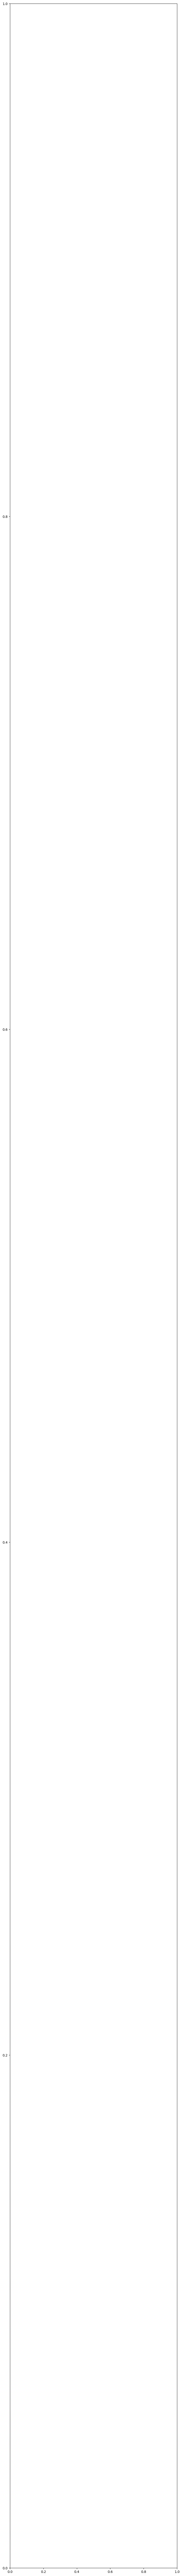

In [68]:
# TODO: fixen dat dit werkt. Nice to have: omschrijven naar een plotly plot

# a) Maak een staafdiagram om de relatie tussen de dummies en de te voorspellen variabele te onderzoeken, bekijk 
# specifieke variabelen om het aantal tabbelen overzichtelijk te houden

dummies = [
    'CONSTRUCTIE_EXP_Nekaldietmof'
]


plt.figure(figsize=(20,140))
for i, column in enumerate(dummies):
    plt.subplot(math.ceil(len(dummies)/2), 2, i+1)
    sns.barplot(df[column], df[target], palette='Blues')
plt.show()

In [ ]:
#  b) Laat een correlatie matrix zien om correlaties tussen alle variabelen te onderzoeken, bekijk
# specifieke variabelen om de matrix overzichtelijk te houden

columns = ['???'
          ]

correlation = inputdata[columns]
corrmat = correlation.corr().round(2)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, cmap='RdBu_r')
plt.show()


# TODO: een aantal verdiepende vragen stellen over de interpertatie van de grafieken. Welke variableenen lijken een voorspellende waarde te hebben?


<a id="5"></a> 


## 5. Splits train- en testset

In [1]:
# TODO: hier nog uitleggen waarom we dit doen en opweg helpen. Eventueeel een linkje naar een sklearn functie met uitleg
# TODO: duidelijk maken hoe de data gestructureerd dient te worden
# TODO: nice to have: analyse van inhoudelijke verdeling tussen train en test set

<a id="6"></a> 


## 6. Train en valideer modellen

# TODO: hoog over uitleg van de verschillende modellen, linkjes naar wiki/documentatie paginas van de modellen. Hoeft niet te uitgebreidt, maar als naslag werk
# TODO: zorgen dat de functies hieronder commentaar hebben van wat ze doen en evt linkjes naar documentatie paginas

In [ ]:
# TODO: het trainen van de modellen en de validatie los trekken van elkaar. Dus generieke validatie functies schrijven voor bijv de auc/roc en cutoff berekeningen



<a id="6a"></a> 
## Decision Tree

In [ ]:
# Laat de namen van alle variabelen zien
data_train.columns.values

In [ ]:
# Definieer X en y 
X_variables = ['???']
y_variable = '???'

X_train = data_train.loc[:, X_variables]
y_train = data_train[y_variable]
X_test = data_test.loc[:, X_variables]
y_test = data_test[y_variable]

In [ ]:
# a) Kies de model parameters 
#    Note: als Min_bucket te groot is, kan de tree mogelijk niet splitsen, als het te klein is wordt de tree misschien te 
#    groot om te interpreteren
Min_num_splits = ??                            # Minimum hoeveelheid van items te splitten
Min_bucket     = ??                            # Minimum hoeveelheid van items per bucket
Max_depth      = ??                            # Maximum depth of final tree (nr of levels)

In [ ]:
# b) Estimate het model 


In [ ]:
# c) Maak voorspellingen voor de test set



#    Laat de eerste 5 rijen van de voorspelling probabilities en de overeenkomende voorspelling zien
pd.concat([pd.DataFrame(preds_proba, columns=["Prob. 0", "Prob. 1"]), pd.DataFrame(preds, columns=["Prediction"])], axis=1).head()

In [ ]:
#    Bereken het optimale cut-off punt
cost_TP = ??
cost_TN = ??
cost_FP = ??
cost_FN = ??
total_cost = math.inf

for i in np.linspace(0,1,100,endpoint=False):
    y_pred = (preds_proba[:,1]>i).astype('int')
    results = metrics.confusion_matrix(y_pred,y_test)
    TN = results[0][0]
    FN = results[0][1]
    FP = results[1][0]
    TP = results[1][1]
    
    # Bereken cutoff-punt
    cost = TN*cost_TN + TP*cost_TP + FP*cost_FP + FN*cost_FN
    total_cost = min(total_cost,cost)
    if(total_cost == cost):
        opt_cutoff = i
        
print('Optimale cut-off:', opt_cutoff)

#    Maak voorspellingen voor de test set met het optimale cut-off punt
preds = (preds_proba[:,1] > opt_cutoff).astype('int')
print(preds)

In [ ]:
#    bepaal wat de 200 moffen zijn met de grootste kans om te falen
chanceOfFailure = preds_proba[:,1]

moffenPerJaar = 200
cutOffChance = np.sort(chanceOfFailure)[::-1][moffenPerJaar]

predictions = ??

In [ ]:
#    Plot tpr vs 1-fpr
fpr, tpr, t = metrics.roc_curve(y_test, preds_proba[:,1])
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i)
                    ,'1-fpr' : pd.Series(1-fpr, index = i)
                    ,'tf' : pd.Series(tpr - (1-fpr), index = i)
                    ,'thresholds' : pd.Series(t, index = i)})
print(roc.loc[(roc.tf-0).abs().argsort()[:1]])
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.title('Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('1-False Positive Rate')
ax.set_xticklabels([])
plt.show()

In [ ]:
# d) Evalueer resultaten
#    i. Maak een confusion matrix


In [ ]:
#    ii. Maak een classificatie rapport


In [ ]:
#    iii. Verkrijg de feature importances van de tree
importances = mytree.feature_importances_ 
std = np.std([mytree.feature_importances_], axis=0)
indices = np.argsort(importances)[::-1]

importances_features = []
print("Feature ranking:")                    # Print the feature ranking
for f in range(X_train.shape[1]):
    print("Feature %d (%s) %f" % (indices[f], X_variables[indices[f]], importances[indices[f]]))
    importances_features.append(X_variables[indices[f]])

plt.figure(figsize=(7.5,5))
plt.figure()                                 # Plot the feature importances 
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.title("Feature importances")
plt.ylabel("Importance in terms of decreasing the weighted impurity")
plt.xlabel("Feature")
plt.xticks(range(X_train.shape[1]), importances_features, rotation = 30)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
#    iv. Maak de ROC curve
fpr, tpr, t = metrics.roc_curve(y_test, preds_proba[:,1])

#     v. Bereken AUC
CART_roc_auc_tree = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,6))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')      # Plot results
plt.plot(fpr, tpr, lw=2, alpha=0.3, label='Mean ROC Decision Tree CART (AUC = %0.2f)' % (CART_roc_auc_tree))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# e) Visualizeer de Decision Tree
dot_data = StringIO()
export_graphviz(mytree, out_file=dot_data,           # mytree := name of your decision treee
                filled=True, rounded=True,
                feature_names=X_variables,
                special_characters=True)
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

<a id="6b"></a> 
## Random Forest 

In [ ]:
# Definieer de train en test set

X_train = data_train.loc[:, X_variables]
y_train = data_train[y_variable]
X_test = data_test.loc[:, X_variables]
y_test = data_test[y_variable]

In [ ]:
# a) Kies de model parameters 
#     Note: Je kan de grootte van je forest aanpassen met N_trees, maar let er op dat de berekeningsduur dan toeneemt
#     Note: Als Min_bucket te groot is, splitsen de trees misschien niet
N_trees        = ??                           # Hoeveelheid estimated trees
Min_num_splits = ??                            # Minimum hoeveelheid van te splitten items    
Min_bucket     = ??  # Minimum hoeveelheid van items per bucket
Max_depth      = ??                            # Maximum depth van iedere tree (hoeveelheid levels)

In [ ]:
# b) Estimate het model



In [ ]:
# c) Maak voorspellingen voor de test set



#    Laat de eerste 5 rijen van de voorspelling probabilities en de overeenkomende voorspelling zien


In [ ]:
#    bepaal wat de 200 moffen zijn met de grootste kans om te falen



In [ ]:
# d) Evaluaeer resultaten
#    i. Maak een confusion matrix


In [ ]:
#    ii. Maak een classificatie rapport



In [ ]:
#    iii. Verkrijg de feature importances van de tree
importances = forest.feature_importances_ 
std = np.std([forest.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

importances_features = []
print("Feature ranking:")                    # Print the feature ranking
for f in range(X_train.shape[1]):
    print("Feature %d (%s) %f" % (indices[f], X_variables[indices[f]], importances[indices[f]]))
    importances_features.append(X_variables[indices[f]])

plt.figure(figsize=(7.5,5))
plt.figure()                                 # Plot the feature importances 
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.title("Feature importances")
plt.ylabel("Importance in terms of decreasing the weighted impurity")
plt.xlabel("Feature")
plt.xticks(range(X_train.shape[1]), importances_features, rotation = 30)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
#    iv. Maak de ROC curve


#     v. Bereken de AUC


plt.figure(figsize=(10,6))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')      # Plot results
plt.plot(fpr, tpr, lw=2, alpha=0.3, label='Mean ROC Decision Tree RF (AUC = %0.2f)' % (RF_roc_auc_tree))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

<a id="6v"></a> 
## XGBoost

In [ ]:
# Definieer X and y 
X_variables = ['???'             # ADJUST VARIABLES TO THOSE YOU WISH TO INCLUDE
                ]
y_variable = '??'

X_train = data_train.loc[:, X_variables]
y_train = data_train[y_variable]
X_test = data_test.loc[:, X_variables]
y_test = data_test[y_variable]

print(X_variables)

In [ ]:
# a) Kies de model parameters 
N_trees        = ??                         # Hoeveelheid estimated trees
Max_depth      = ??                             # Maximum depth van iedere tree (hoeveelheid levels)
Learning_rate  = ??                             # The learning rate ('eta')
Min_bucket     = ??                           # Minimum hoeveelheid van items per bucket
Subsample      = ??                          # Subsample ratio van de training instance
Verbose        = ??                             # Of er tijdens het boosten berichten geprint moeten worden


In [ ]:
# b) Estimate model


In [ ]:
# c) Maak voorspellingen voor de test set

#    Laat de eerste 5 rijen van de voorspelling probabilities en de overeenkomende voorspelling zien



In [ ]:
#    bepaal wat de 200 moffen zijn met de grootste kans om te falen
chanceOfFailure = preds_proba[:,1]

moffenPerJaar = 200
cutOffChance = np.sort(chanceOfFailure)[::-1][moffenPerJaar]

predictions = np.array([True if chance > cutOffChance else False for chance in chanceOfFailure])

index_values = np.where(predictions == True)
print(index_values)

In [ ]:
# d) Evalueer de resultaten
#    i. Maak een confusion matrix
print(pd.crosstab(preds, y_test))

In [ ]:
#    ii. Maak een classificatie rapport
print(classification_report(y_test, preds))
f1_XGB = f1_score(y_test, preds)

In [ ]:
#    iii. Krijg de feature importances van het XGBoost model
importances = XGB.feature_importances_ 
std = np.std([XGB.feature_importances_], axis=0)
indices = np.argsort(importances)[::-1]

importances_features = []
print("Feature ranking:")                    # Print the feature ranking
for f in range(X_train.shape[1]):
    print("Feature %d (%s) %f" % (indices[f], X_variables[indices[f]], importances[indices[f]]))
    importances_features.append(X_variables[indices[f]])

if False:
    plt.figure(figsize=(7.5,5))
    plt.figure()                                 # Plot the feature importances 
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.title("Feature importances")
    plt.ylabel("Importance in terms of decreasing the weighted impurity")
    plt.xlabel("Feature")
    plt.xticks(range(X_train.shape[1]), importances_features, rotation = 30)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

In [ ]:
# Maak de ROC curve


# Bereken AUC


plt.figure(figsize=(10,6))
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')      # Plot results
plt.plot(fpr, tpr, lw=2, alpha=0.3, label='Mean ROC Decision Tree XGBoost (AUC = %0.2f)' % (XGB_roc_auc_tree))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

# 8: Conclusie

In [ ]:
# TODO: beantwoorden van business vragen en het trekken van conclusie